In [101]:
import networkx as nx
import json
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import networkx.algorithms.centrality
from networkx.algorithms.community.kclique import k_clique_communities
import pickle
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
import collections
from pyspark.ml.evaluation import RegressionEvaluator
%matplotlib inline

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
selected_city = 'Tempe'

In [4]:
df_business = spark.read.json("data/yelp_academic_dataset_business.json")
df_reviews = spark.read.json("data/yelp_academic_dataset_review.json")
df_users = spark.read.json("data/yelp_academic_dataset_user.json")

In [5]:
df_subset_business = df_business.filter(df_business['city'] == 'Tempe')
df_subset_business.count()

4492

## only select those reviews that are in the selected cities.

In [6]:
selected_reviews = df_reviews.join(df_subset_business, "business_id").select("review_id", "business_id", "user_id")

In [7]:
selected_reviews.show()

+--------------------+--------------------+--------------------+
|           review_id|         business_id|             user_id|
+--------------------+--------------------+--------------------+
|HkYqGb0Gplmmk-xlH...|UBv8heCQR0RPnUQG0...|NhOc64RsrTT1Dls50...|
|RgqWdZA4xR023iP3T...|hdgYnadxg0GANhWOJ...|NhOc64RsrTT1Dls50...|
|XIZeDNZdGnPvq6gGl...|VfX7rhtX03yNg56IS...|0pf5VuzE4_1pwj5NJ...|
|bkmJq3-uuvhTEpCnN...|TT4XW2WMG0PNyUIFB...|wn5sc78bQn-FpuR2u...|
|ezOskeLKOq9xd-815...|x2NuIlQgvvl3Wtq8i...|jjSR3JpsYKIgMUSR5...|
|AmDKzAWJJ8vsYJ36O...|Wmrc1Yro_BLHGU3Us...|JIkVfsVYb7-26O3Bx...|
|KCyFAZ2c3Zu7V606D...|tL9003ETHUAcHF-ea...|60Z_adXWeE2rC2HDe...|
|5BBCAIxXTZ2B2ZBe6...|qiR7S83_7Du_XQyj_...|60Z_adXWeE2rC2HDe...|
|A4kB6UC3H34PmtS-q...|nChi_8Gygb6NUMa_k...|60Z_adXWeE2rC2HDe...|
|nyLiv84Cm9Tk1BAEN...|QZJpXx1TbOXqzLx6u...|60Z_adXWeE2rC2HDe...|
|hMKoHll-OFEyKzYRT...|DVhSFWIJKk4Vo8fjy...|s0X0vCfR0X3oA3iMb...|
|aAZx8qzkle7T8lhvA...|e-hztV3mlfn5z8VmR...|nDdcMqgQkRZuvjRzX...|
|S95ZsFVPVVCbKgDz1...|hIg

## only select those users whose reviews falls in the above but also has a social network

In [8]:
selected_reviews.select('user_id').distinct().show()

+--------------------+
|             user_id|
+--------------------+
|WpSrLMVhGGLk6fXKp...|
|8O4185hyq32Rjv3sA...|
|eEgYjk-9s9g2RWTnH...|
|FC_As88OdIdVKEb4s...|
|nQYAm2su7RpAPyfkj...|
|W2lmuHkD98eF38Ys2...|
|Gj_SaBaBMo5HNdW22...|
|UbYbdAXEy8Q9zHcLN...|
|Rrj_TMC2pERnYW8-Q...|
|btf3BC_4eOItKEnv7...|
|yEzwUi_ekHk6O8Q7i...|
|QrGOuhWY3dzay4sCB...|
|LXv8RdhhvR2Cev9Ts...|
|FmbHRZqh49BZ_NgzN...|
|0NuimT3Pu7hZAIghg...|
|FcPizV6LBFNe_Y00E...|
|7CsB489EU7LJwj5ha...|
|_YJ9ZLPI2UYhh-jGQ...|
|Al2g2P9gt057Julh1...|
|pwUK10cUmXX3C-2Vl...|
+--------------------+
only showing top 20 rows



In [9]:
selected_users = selected_reviews.select('user_id').distinct().join(df_users, 'user_id').select("user_id", "friends")
selected_users = selected_users.filter(selected_users["friends"] != 'None')

In [10]:
selected_users.count()

56663

In [11]:
selected_users.select('user_id').show(truncate=False)

+----------------------+
|user_id               |
+----------------------+
|-dV1Z7attfgdpyNpZCtoaw|
|-inp099-1gsJF3KPaS-mbg|
|0o5iPlFr5-kLp7fzdkDbBQ|
|0r_my8LsjiK47lDin41SRw|
|0y8ORuC2X1i1UF6SG1hlkQ|
|1Be7EnTB-fRnt93N6JX_JA|
|1EAAQLN-TrVGXLquzXCQQQ|
|1Q-tjPYDBaFZJouj8Ynl2g|
|1jnui28Rs1M-p0jkAolP1w|
|1jtr65gmv4A3uqCDaaXcxQ|
|2OtKt_7AZkfPXioU317R7g|
|2SawL1rTPfaj92ph1-d3sg|
|2oD-vur-aVCsOVdW0iUevw|
|2of05wcCkmBqguHtHSmOqg|
|3Brc8vhk5dwtBAZHeUZ-OQ|
|3UA89mI2pN2KphXN3QXPIQ|
|3c_LCy_UwFzo6mmW0xG3JQ|
|3g-2-nE22LxldS3Rx5IzNg|
|3rWUVww0VKB8_LC774hhYw|
|46wwNRiBGIAJuPlk8TOP_g|
+----------------------+
only showing top 20 rows



## sample 10% of the users to make the graph smaller

In [12]:
selected_users = selected_users.sample(fraction=0.4, seed=2018)

In [13]:
users_set = set(r['user_id'] for r in selected_users.collect())

In [14]:
len(users_set)

22588

In [15]:
users = selected_users.collect()
G = nx.Graph()
for r in users:
    friends = r['friends'].split(', ')
    friends = [f for f in friends if f in users_set]
    for f in friends:
        G.add_edge(r['user_id'], f)

In [16]:
G.number_of_edges()

35416

In [17]:
G.number_of_nodes()

12019

## plot degree distribution

In [18]:
def plot_degree_distribution (G) :
    degs = {}
    for n in G . nodes () :
        deg = G . degree ( n )
        if deg not in degs :
            degs [ deg ] = 0
        degs [ deg ] += 1
    items = sorted ( degs . items () )
    fig = plt . figure ()
    ax = fig . add_subplot (111)
    ax . plot ([ k for (k , v ) in items ] , [ v for (k ,v ) in items ])
    ax . set_xscale ( 'log')
    ax . set_yscale ( 'log')
    plt . title ( " yelp users Degree Distribution " )
#     fig . savefig ( " degree_distribution . png " )

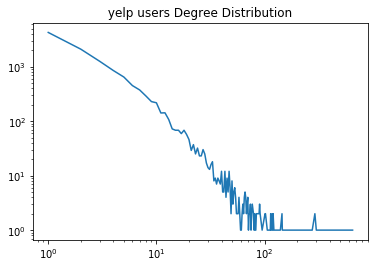

In [19]:
plot_degree_distribution(G)

In [ ]:
networkx.algorithms.centrality.degree_centrality(G)

In [23]:
c = k_clique_communities(G, 3)

In [24]:
clique_list = list(c)

In [29]:
with open('3_clique.pkl', 'wb') as output:
    pickle.dump(clique_list, output, pickle.HIGHEST_PROTOCOL)

In [30]:
clique_list

[frozenset({'uAZ6Sp3uaH3TIztZqqtmPw',
            'S05ujQ92h7YNDzY6u7wr_A',
            'JecVwE013vUjG35edSNzxA',
            'r8GvTlIHM_X60CJNnFG1LA',
            'M8Gtdxk23L4ztJpb7hPw1w',
            '4HgsGbI8v6-703hjqG2hVw',
            'DKdttAvXagfAfNFIKeApuw',
            'rN4RItq4xONM-cjgSfbvDQ',
            'qdTvLhWpNy_kg7sCN6NIGg',
            'AGpnVxWBOSsLw4VuC81q7A',
            'DH33jk6JCu18bDttLCalRw',
            'eufqj-rw0EzK4OEisc-qTQ',
            '2COnPVLZlgzDQ1yvD39ktw',
            's9j6bdRvM-MEpLGkOoiH9g',
            'tYjI8jXm2IyH8DQNngvmfw',
            'vTugBdYg34rX4KvGpzBrNA',
            'IBiHQzvzP01UNuLbADSz4A',
            'sKd6tuqt1W9HHYG3ZEO9xg',
            '3MpMmsUoZJI_8MtEGN-KsQ',
            '2TAvvTz9E6AOYObB9OOjaw',
            'mfdb2wCYv7yiu0fyzFKMBg',
            '8R4wogriO2TwadlxyeV01A',
            'jzkbhkRdjWPwTIOgRGggIg',
            'Js-e3oQBDqQY_JzF7VLjBA',
            'bgAwpv9WxE4-txsUd2jasQ',
            '6AMwQ8cFWIKGbGpVwehkfw',
            

In [31]:
users_set

{'u3JpeA9H57aIJr8EDBo4RA',
 'FoXxQLisWKKu1yckzel4hg',
 'm1SC4n0zCodg47x9qsc5YA',
 'UAIrP0EsPuCTfKx0JC8shw',
 's9j6bdRvM-MEpLGkOoiH9g',
 'NcKCvQyx6g25esU9Tvvtfg',
 'IKZdOX6bMCIQssnRII8zIQ',
 'P13Ok0Kbk9oL1lnKvTAadA',
 'nXJih9TWjQ678v6XLERcYw',
 'CDHORt_NH2R6ySLHZ4npmg',
 '03shxZmX23VnrbKoqmbFYw',
 'IUu5YA9IcPVf0ATW4quwLw',
 'VfLntbLE7_wVJ6MlweQcSg',
 'KmE0figYv3IBVDJqwnc8HQ',
 'QXFmIRnh1HsxHEbSWIfLtg',
 'BJGigaqQf6Q_KEtBjM29rg',
 'FZX9ewx-JRIClSyVCP7JWQ',
 'emN4aZGAmU7ocMTBOKwl0Q',
 'axI2YBD4nJMD10HHR6B3hg',
 'afCoTK0q_Y_UioCvKq_UQQ',
 '7qstyjVDSuQGNzpV0HDjbA',
 'PQNqZUHRJv2PDt6ybfj3iA',
 'UYJctmTh3kvofuabFZK1rw',
 'wdYw4p8KGlkVelP1jI6PBA',
 'kEVx04ERpkuFXKuUaoZayQ',
 'PGK3wu4UPiyyl6pPemhKsw',
 'ftX9hskuE_aXHlCwly1KJg',
 'mGbXqRqPt_q-r4VUp7AJUw',
 'zjBwYaJRP7Ju0Q30pOKkRw',
 'oDPt5VvwAe8kD2xH9Q3XfA',
 'gGCCChJlTMtykqd7pF6hXQ',
 'qUUK0IhJh5d2BZn1dKUNBg',
 'WjzST5w1nb1CGlFoP7ceDA',
 'hazFjLv3rVO_9V9wSQ55Gw',
 'CaUMgE0ukG4QBsQJVMhXOA',
 'YgTl7LyKWSNGCuWNfvlfEg',
 'ETsn7NikWn_oF8WHZCCzXw',
 

In [38]:
len(G.nodes())

12019

In [39]:
clique_membership = {}
for n in G.nodes:
    for i, clique in enumerate(clique_list):
        if n in clique:
            clique_membership[n] = i
            break
len(clique_membership)

4063

## the users that I'm gonna use for benchmarking

In [48]:
users_to_use = set(clique_membership.keys())

In [56]:
def inset_filter(x):
    return x in users_to_use
filter_udf = udf(inset_filter, BooleanType())

reviews_to_benchmark = df_reviews.select("user_id", "business_id", "stars").filter(filter_udf(df_reviews['user_id']))

In [61]:
r_t_b_collected = reviews_to_benchmark.collect()

In [64]:
review_ref = collections.defaultdict(dict)
for r in r_t_b_collected:
    review_ref[r['user_id']][r['business_id']] = r['stars']
    

In [66]:
len(review_ref.keys())

4063

In [69]:
avg_biz_stars = df_reviews.groupBy('business_id').agg({'stars': "avg"}).collect()

In [71]:
df_reviews.groupBy('business_id').agg({'stars': "avg"}).show()

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|JsUytp_MuZ4AX5JWf...|3.4601769911504423|
|t5nyOtnEv455rShOS...| 4.396270396270396|
|JFhfVTt_8xNjtwqSD...|             3.096|
|YYWkJwfO1HApuHiW-...|3.5405405405405403|
|35X1ZV9tSEqB__yJE...|2.9934065934065934|
|tuikCn2ljRGN5QHZB...|           2.96875|
|rbH0HuTcBvZBbiAnq...| 4.452702702702703|
|llCxryWr8j1S39tus...|4.3534883720930235|
|QfIJFYIVeZQ3phDJ9...|3.8947368421052633|
|JLbgvGM4FXh9zNP4O...|4.1214723926380366|
|Ghn4p2M-TsuSXORZx...| 3.411764705882353|
|UhEhLSJrPRoiYWdHf...| 4.717741935483871|
|J6WnhToRaJ2TtLbRp...| 4.891891891891892|
|o112Vh27kc6jryoWX...| 4.357142857142857|
|gjQ20S96ScTc7LR_D...|               4.0|
|RtUvSWO_UZ8V3Wpj0...| 4.139356814701379|
|zSFutuGG7NcL60-N9...| 2.788732394366197|
|UdMrPZIXPTZfKhHBw...|               5.0|
|sOs9goJyHT5Ggu1hT...|3.7244094488188977|
|Yemfgx9S_UzK9Rbqp...|               1.8|
+--------------------+------------

In [72]:
avg_stars_ref = {}
for r in avg_biz_stars:
    avg_stars_ref[r['business_id']] = r[r"avg(stars)"]

In [83]:
prediction = collections.defaultdict(dict)
for r in r_t_b_collected:
    user = r['user_id']
    business = r['business_id']
    friends= set(clique_list[clique_membership[user]])
    friends.remove(user)
    s = 0
    co = 0
    for uf in friends:
        rate = review_ref[uf].get(business)
        if rate:
            s += rate
            co += 1
    if co == 0:
        prediction[user][business] = avg_stars_ref[business]
    else:
        prediction[user][business] = s / co

In [84]:
len(prediction)

4063

In [85]:
prediction

defaultdict(dict,
            {'LBweMNqEoQi9_-7HhNcWQg': {'fI9ErCUGY8rXRPBbatcxMA': 4.0,
              'NJ0RzuWd5xDqfJejYQZ65g': 3.7851239669421486,
              'tTR9GQbdC-rEHNsECmSWRw': 4.2,
              'm5niZy68d2gTtVWz89elfA': 4.0,
              '7pGWy3mR7gjMSE6x2njqPA': 3.793103448275862,
              'U7fZfH9C4hj5BFRYaPOo2w': 3.9,
              'B8zMmUlCIX7Ts8VSgy9B-A': 3.1666666666666665,
              'UE3AvVnaPEBPneVahYT2eA': 4.054545454545455,
              '-050d_XIor1NpCuWkbIVaQ': 3.9176470588235293,
              'aD-YA02i2xAqLBDon1tzIQ': 4.021739130434782,
              'QS3QxI7u5PRdtbGgI0-UsA': 4.216216216216216,
              'YPavuOh2XsnRbLfl0DH2lQ': 4.163934426229508,
              '33aT8mN5sshpmNReMeuiZA': 4.65,
              '89uU51kOiQXbJHVA3C6XMQ': 3.958904109589041,
              'DymZ5vpm7vkSsR__-4sflw': 4.105263157894737,
              'kUuJ8TDXWz8J2Tnz2sqtuA': 3.6666666666666665,
              'rxjHvIvV_BlzKa8ftRUpGA': 4.083333333333333,
              'Iso

In [86]:
prediction_to_list = []
for u in prediction:
    for b in prediction[u]:
        prediction_to_list.append((u, b, prediction[u][b]))

In [87]:
df_reviews_pred = spark.createDataFrame(prediction_to_list, ['user_id', 'business_id', 'stars_pred'])

In [88]:
df_reviews_pred.show()

+--------------------+--------------------+------------------+
|             user_id|         business_id|        stars_pred|
+--------------------+--------------------+------------------+
|LBweMNqEoQi9_-7Hh...|fI9ErCUGY8rXRPBba...|               4.0|
|LBweMNqEoQi9_-7Hh...|NJ0RzuWd5xDqfJejY...|3.7851239669421486|
|LBweMNqEoQi9_-7Hh...|tTR9GQbdC-rEHNsEC...|               4.2|
|LBweMNqEoQi9_-7Hh...|m5niZy68d2gTtVWz8...|               4.0|
|LBweMNqEoQi9_-7Hh...|7pGWy3mR7gjMSE6x2...| 3.793103448275862|
|LBweMNqEoQi9_-7Hh...|U7fZfH9C4hj5BFRYa...|               3.9|
|LBweMNqEoQi9_-7Hh...|B8zMmUlCIX7Ts8VSg...|3.1666666666666665|
|LBweMNqEoQi9_-7Hh...|UE3AvVnaPEBPneVah...| 4.054545454545455|
|LBweMNqEoQi9_-7Hh...|-050d_XIor1NpCuWk...|3.9176470588235293|
|LBweMNqEoQi9_-7Hh...|aD-YA02i2xAqLBDon...| 4.021739130434782|
|LBweMNqEoQi9_-7Hh...|QS3QxI7u5PRdtbGgI...| 4.216216216216216|
|LBweMNqEoQi9_-7Hh...|YPavuOh2XsnRbLfl0...| 4.163934426229508|
|LBweMNqEoQi9_-7Hh...|33aT8mN5sshpmNReM...|            

In [89]:
reviews_to_benchmark.show()

+--------------------+--------------------+-----+
|             user_id|         business_id|stars|
+--------------------+--------------------+-----+
|LBweMNqEoQi9_-7Hh...|fI9ErCUGY8rXRPBba...|    4|
|LBweMNqEoQi9_-7Hh...|NJ0RzuWd5xDqfJejY...|    5|
|LBweMNqEoQi9_-7Hh...|tTR9GQbdC-rEHNsEC...|    1|
|LBweMNqEoQi9_-7Hh...|m5niZy68d2gTtVWz8...|    5|
|LBweMNqEoQi9_-7Hh...|7pGWy3mR7gjMSE6x2...|    5|
|LBweMNqEoQi9_-7Hh...|U7fZfH9C4hj5BFRYa...|    5|
|LBweMNqEoQi9_-7Hh...|B8zMmUlCIX7Ts8VSg...|    3|
|LBweMNqEoQi9_-7Hh...|UE3AvVnaPEBPneVah...|    4|
|LBweMNqEoQi9_-7Hh...|-050d_XIor1NpCuWk...|    5|
|LBweMNqEoQi9_-7Hh...|aD-YA02i2xAqLBDon...|    4|
|LBweMNqEoQi9_-7Hh...|QS3QxI7u5PRdtbGgI...|    5|
|LBweMNqEoQi9_-7Hh...|YPavuOh2XsnRbLfl0...|    3|
|LBweMNqEoQi9_-7Hh...|33aT8mN5sshpmNReM...|    5|
|LBweMNqEoQi9_-7Hh...|89uU51kOiQXbJHVA3...|    5|
|LBweMNqEoQi9_-7Hh...|DymZ5vpm7vkSsR__-...|    4|
|LBweMNqEoQi9_-7Hh...|kUuJ8TDXWz8J2Tnz2...|    3|
|LBweMNqEoQi9_-7Hh...|rxjHvIvV_BlzKa8ft...|    4|


In [95]:
cond = [reviews_to_benchmark['user_id'] == df_reviews_pred['user_id'], reviews_to_benchmark['business_id'] == df_reviews_pred['business_id']]
table_joined = reviews_to_benchmark.join(df_reviews_pred, cond).select('stars', 'stars_pred')

In [102]:
evaluator = RegressionEvaluator(predictionCol='stars_pred', labelCol='stars', metricName='rmse')

In [103]:
evaluator.evaluate(table_joined)

1.1574078577988616